## Severstal: Steel Defect Detection

This is to build a predictive model for the Kaagle competition - Severstal: Steel Defect Detection. There are steel images with different categories of defects in specific pixels on these images. Our task is to find out where do the defects locate using pixel to demonstrate, and also to distinguisg to which defect category(1, 2, 3, or 4)they belong.

For details, please refer to https://www.kaggle.com/c/severstal-steel-defect-detection

### Outline
The all process would be summarized into the following steps.

> **1. Data preprocessing and EDA** - In this sector, I'll load the *train.csv* and also the image IDs from *train_images* folder, and collected them into dafaframes for clearer information.

> **2. Functions needed** - I designed some functions in this sector for later use.

> **3. Build first model** - The first model is to predict whether there are some defects in each image

> **4. Build second model** - The second model is to predict the defects' pixel location on the images which were predicted as *with defect* from the first model

> **5. Make prediction on the test images**

### Pre-work
Please mount with your gmail account, and reset the directory path to where you stored your data in order to run my code successfully. I recommand to run this code on Google Colab to avoid unexpected errors.

In [ ]:
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_dir = '/content/drive/My Drive/Colab Notebooks/QBS HW3'
train_dir = base_dir + '/train_images'
test_dir = base_dir + '/test_images'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc

import os
import cv2
from sklearn.model_selection import train_test_split

import keras
from keras import layers
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

### Data preprocessing and EDA

#### Build training-related dataframes

In [ ]:
train_csv = pd.read_csv(base_dir +"/train.csv")
train_csv.head(10)

,ImageId,ClassId,EncodedPixels
0,1,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,5,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,6,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,7,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,8,3,229501 11 229741 33 229981 55 230221 77 230468...
5,12,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
6,12,4,315139 8 315395 15 315651 16 315906 17 316162 ...
7,13,4,290800 6 291055 13 291311 15 291566 18 291822 ...
8,16,4,186833 1 187089 3 187344 6 187600 7 187855 10 ...
9,18,3,152926 1 153180 4 153434 6 153689 8 153943 11 ...


The folloing will build two dataframes.

    defect_train_df: only cantains the training images with defects
    train_df_all: contains all training images




And I also counted the number of classes with defects for each image id in these dataframes to separate images into with defects and without defects for later uses.



In [ ]:
# Calculate defect category numbers from csv(only include the images that have defects)
defect_train_df = train_csv['ImageId'].value_counts().rename_axis('ImageId').to_frame('defect_cnt')

# Transfer the index(ImageId) data type into 'int' in order for later sorting
defect_train_df.index = defect_train_df.index.astype('int')
defect_train_df.sort_values('defect_cnt', ascending=False, inplace=True)
defect_train_df.head()

,defect_cnt
ImageId,
11777,3
10804,3
1997,2
12281,2
10357,2


The above are some images with multiple defect categories in one image. For example, for image with ID = 11777, this image has 3 categories of defects in total.

The above dataframe, ***defect_train***, from the train.csv file only includes the images with defect. Since we need to consider all images in the training set and we need all image IDs in order to separate images into with and without defects in the first place, we obtain ALL training image IDs from the images names in the ***train_images*** folder.

In [ ]:
# Obtain ALL image IDs from the images folder and take .JPD away from them
# os.listdir(path) will return a list containing all file names in the given path, so we can get a list with all image names
train_df_all = pd.DataFrame(os.listdir(train_dir), columns = ['File name'])
train_df_all['ImageId'] = train_df_all['File name'].apply(lambda x: x.split('.')[0])
train_df_all['ImageId'] = train_df_all['ImageId'].astype('int')
train_df_all.set_index('ImageId', inplace=True)

# Build the dataframe with defect_cnt column which includes ALL images
train_df_all['defect_cnt'] = defect_train_df['defect_cnt']

# If the image isn't is defect_train_df, that means that it has no defects. So we fill them with zero
train_df_all['defect_cnt'].fillna(0, inplace = True)
train_df_all['defect_cnt'] = train_df_all['defect_cnt'].astype('int')
train_df_all.drop('File name', axis=1, inplace=True)
train_df_all.head()

,defect_cnt
ImageId,
9939,0
9773,0
4444,0
10871,0
11654,1


In [ ]:
print(train_df_all.shape)
print(defect_train_df.shape)

(8798, 1)
(4682, 1)


There are 8798 images in the training data set in total, and 4682 of them are with defects. Therefore, we know that 4116 images are with no defects, which is around 46.8%. So the data distributes quite equal among w/o defect images.

---



For later use, I moved ImageId from indexes to a column and also sort by ImageId for cleaner information.

In [ ]:
# move ImageId to column and sort by ImageId and reset index
def reformat(df):
  df = df.reset_index(level=0).sort_values(by = ['ImageId']).reset_index(drop = True)
  return df

In [ ]:
# reformat the dataframes
train_df_all = reformat(train_df_all)
defect_train_df = reformat(defect_train_df)

In [ ]:
train_df_all.head()

,ImageId,defect_cnt
0,1,1
1,2,0
2,3,0
3,5,1
4,6,1


In [ ]:
defect_train_df.head()

,ImageId,defect_cnt
0,1,1
1,5,1
2,6,1
3,7,1
4,8,1


And since we want to predict a yes/no question in the first place, I add a new column ***No_defect***.

    No_defect: 1 for images without defects, and 0 for those with defects

In [ ]:
# Create defect_yn_df and add 'No_defect' column
defect_yn_df = train_df_all.copy()
defect_yn_df['No_defect'] = str(0)
no_defect_index = defect_yn_df[ defect_yn_df.loc[:,'defect_cnt'] == 0].index
defect_yn_df.iloc[no_defect_index,2]= str(1)

# Create 'File name' column, which is usable for flow_from_dataframe() function when building DataGenerator class later
defect_yn_df['ImageId'] = defect_yn_df['ImageId'].astype('str')
defect_yn_df['File name'] = defect_yn_df['ImageId'] + '.JPG'
defect_yn_df.head()

,ImageId,defect_cnt,No_defect,File name
0,1,1,0,1.JPG
1,2,0,1,2.JPG
2,3,0,1,3.JPG
3,5,1,0,5.JPG
4,6,1,0,6.JPG


#### Data exploring

The count numbers of each class
1     614
2     189
3    3620
4     562
Name: ClassId, dtype: int64


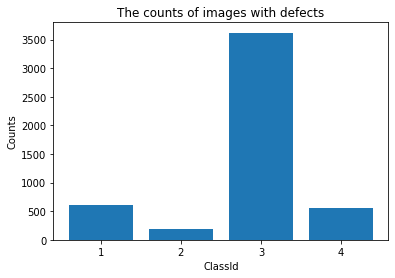

In [ ]:
# To know the defect counts in different categories
series = train_csv['ClassId'].value_counts().sort_index()
print("The count numbers of each class")
print(series)
classId = series.index.astype('str')
counts = series.values
plt.bar(classId, counts, width=0.8)
plt.title("The counts of images with defects")
plt.xlabel("ClassId")
plt.ylabel("Counts")
plt.show()
plt.close()

From the figure, we can found that it's really unbalanced between each categories.

---
How about the counts of defect categories in each image?


1    4381
2     299
3       2
Name: defect_cnt, dtype: int64


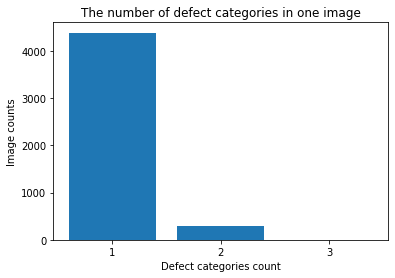

In [ ]:
series = defect_train_df['defect_cnt'].value_counts().sort_index()
print(series)
defect_cnt = series.index.astype('str')
image_num = series.values
plt.bar(defect_cnt, image_num)
plt.title("The number of defect categories in one image")
plt.xlabel("Defect categories count")
plt.ylabel("Image counts")
plt.show()
plt.close()

It shows that there are only one category of defects in most of the images. Some of them have two kinds of defects, and only 2 of them have three categories of defects.


---
We now can show some images.


Image name :  2.JPG


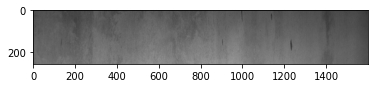

Image name :  3.JPG


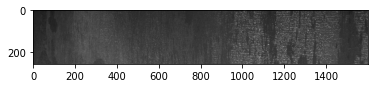

In [ ]:
no_defect = defect_yn_df['File name'][defect_yn_df['defect_cnt']==0].values[:2]
for name in no_defect:
  image = cv2.imread(train_dir + '/' + name)
  print("Image name : ", name)
  plt.imshow(image)
  plt.show()
  plt.close()

Defect ClassId = 1
Image name :  1


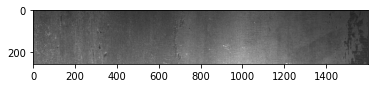

Image name :  6


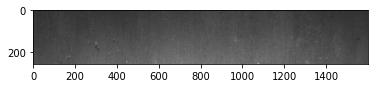

In [ ]:
defect_1 = train_csv['ImageId'][train_csv['ClassId']==1].values[:2].astype(str)
print("Defect ClassId = 1")
for name in defect_1:
  image = cv2.imread(train_dir + '/' + name + '.JPG')
  print("Image ID: ", name)
  plt.imshow(image)
  plt.show()
  plt.close()

Defect ClassId = 2
Image name :  35


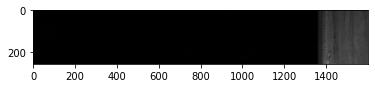

Image name :  38


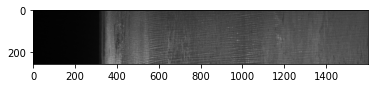

In [ ]:
defect_2 = train_csv['ImageId'][train_csv['ClassId']==2].values[:2].astype('str')
print("Defect ClassId = 2")
for name in defect_2:
  image = cv2.imread(train_dir + '/' + name +'.JPG')
  print("Image name : ", name)
  plt.imshow(image)
  plt.show()
  plt.close()

Defect ClassId = 3
Image name :  5


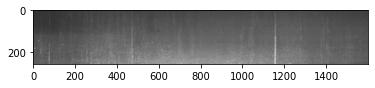

Image name :  8


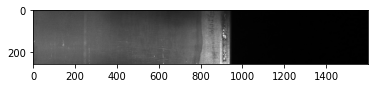

In [ ]:
defect_3 = train_csv['ImageId'][train_csv['ClassId']==3].values[:2].astype('str')
print("Defect ClassId = 3")
for name in defect_3:
  image = cv2.imread(train_dir + '/' + name + '.JPG')
  print("Image name : ", name)
  plt.imshow(image)
  plt.show()
  plt.close()

Defect ClassId = 4
Image name :  7


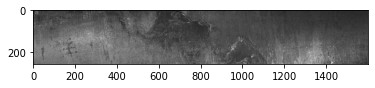

Image name :  12


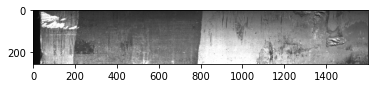

In [ ]:
defect_4 = train_csv['ImageId'][train_csv['ClassId']==4].values[:2].astype('str')
print("Defect ClassId = 4")
for name in defect_4:
  image = cv2.imread(train_dir + '/' + name + '.JPG')
  print("Image name : ", name)
  plt.imshow(image)
  plt.show()
  plt.close()

#### Build testing-related dataframes

In [ ]:
# Build test_df and create ImageId column with all test_images by os.listdir()
test_df = pd.DataFrame(os.listdir(test_dir), columns = ['File name'])
test_df['ImageId'] = test_df['File name'].apply(lambda x: x.split('.')[0])

# Transform ImageId into 'int' in order to sort, and transform it back to 'str' according to later functions requirements
test_df['ImageId'] = test_df['ImageId'].astype('int')
test_df = test_df.sort_values(by = ['ImageId']).reset_index(drop = True)
test_df['ImageId'] = test_df['ImageId'].astype('str')

test_df.head()

,File name,ImageId
0,4.JPG,4
1,10.JPG,10
2,11.JPG,11
3,15.JPG,15
4,17.JPG,17


### Functions needed
I built some functions first in this sector for more convenient usage.
There are
    build_matrices

In [ ]:
def build_matrices(image_category, rles, input_shape):
  """
  This function can build matrices from rles for each image, which are the matrices with 0 and 1 to indicate the defects on the image.
  There are 4 categories in total, so the last shape of returned matrix is 4.
  And the first and second dimension depend on the 'input_shape'.

  image_category : a list including the category with defect for this image, e.g.: [1,4]
  rles : a list containig the string of run-length-encodings for each category, e.g.:['1 2 5 10', '13 5 20 4']
  input_shape : the shape same as the image size, in this case this is 256*1600
  return : an numpy array with dimension = (input_shape[0], input_shape[1], 4)
  """
  matrices = np.zeros((input_shape[0], input_shape[1], 4))
  for i, cate in enumerate(image_category):
    rle = rles[i]
    matrices[:,:,cate-1] = rle_to_matrix(rle, input_shape)
  return matrices

def rle_to_matrix(rle, input_shape):
  """
  This function can transform one rle to one matrix and the dimensions depend on the 'input_shape'.

  rle : one run-length-encoding string
  input_shape : the tuple (a,b), show that the shape which is the same as the image size. In this case it's 256*1600.
  return : an numpy array with shape = (input_shape[0], input_shape[1])
  """
  rows, cols = input_shape[0], input_shape[1] # 256, 1600

  # To simplify the problem, we can store the array with shape = (256*100) at first,
  # and transform it to array with shape = (256, 1600) in the end
  matrix = np.zeros(rows * cols).astype(np.uint8)
  array = np.asarray([int(x) for x in rle.split()])
  starts = array[0::2]   # the start position indexes
  lengths = array[1::2]  # the correspoding lengths for the start positions
  for index, start in enumerate(starts):
     matrix[int(start)-1:int(start+lengths[index])-1] = 1
  return matrix.reshape((cols, rows)).T

def build_rles(matrices):
  """
  This function is to transform the 4 matrices for each image into rles.

  matrices : an numpy array with shape = (a, b, 4), where (a,b) is arbitrarily chosen. In this case it's (256, 1600).
  return : rles, which is a list with 4 strings inside.
  """
  width, height, depth = matrices.shape
  rles = [matrices_to_rle(matrices[:, :, i]) for i in range(depth)]
  return rles

def matrices_to_rle(img):
    '''
    This function is to transfer one numpy array into one rle.

    img: numpy array, 1 - defect, 0 - no defect
    return : rle, run length encoding in string format
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
def plot_loss(history):
  loss = history.history['loss']
  epochs = range(1, len(loss) + 1)
  val_loss = history.history['val_loss']
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  plt.close()

In [ ]:
def plot_acc(history):
  acc = history.history['accuracy']
  epochs = range(1, len(acc) + 1)
  val_acc = history.history['val_accuracy']
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Acuracy')
  plt.legend()
  plt.show()
  plt.close()

In [ ]:
def plot_dice_coef(history):
  dice_coef = history.history['dice_coef']
  epochs = range(1, len(dice_coef) + 1)
  val_dice_coef = history.history['val_dice_coef']
  plt.plot(epochs, dice_coef, 'bo', label='Training dice_coef')
  plt.plot(epochs, val_dice_coef, 'b', label='Validation dice_coef')
  plt.title('Training and validation dice_coef')
  plt.xlabel('Epochs')
  plt.ylabel('dice_coef')
  plt.legend()
  plt.show()
  plt.close()

### Model Building

#### First model - separate w/o defect images

##### Build data generator
We use ImageDataGenerator to create data in batch to lower the RAM used during loading and training process. Besides, for better prediction, we also set zoom and rotation shift effects when generating training images data.

In [ ]:
BATCH_SIZE = 32
def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.1,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,
        rotation_range=10,
        height_shift_range=0.1,
        width_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1/255.,
        validation_split=0.15
    )
def create_train_gen(datagen, subset, target_shape):
    """
    flow_from_dataframe can help us read the images and corresponds them with their data in the dataframe stored.
    Hence, we use defect_yn_df, which contains all training images with their defect information, as a base.
    x_col is the file name, and y_col is No_defect column and is the label that we want to predict.
    """
    return datagen.flow_from_dataframe(
        defect_yn_df,
        directory= train_dir,
        x_col='File name',
        y_col='No_defect',
        class_mode='binary',
        target_size=(target_shape[0], target_shape[1]),
        batch_size=BATCH_SIZE,
        subset=subset,
        seed = 2020,
    )
def create_test_gen(target_shape):
    """
    Similar to those in create_train_gen(), but for test_images there is no label, so we don't need to set y_col.
    And to preserve the output order to be the same as its ImageId so that we can produce the final predictions, we set shuffle = False.
    """
    return ImageDataGenerator(rescale=1/255.).flow_from_dataframe(
        test_df,
        directory=test_dir,
        x_col='File name',
        class_mode=None,
        target_size=(target_shape[0], target_shape[1]),
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

To reduce the training time, I downsized the target_shape from original (256,1600) to (128,400). And after training for both sizes, I thought there wasn't significant differences between them. Therefore, downsizing them for a more efficient training process is a better choice.

In [ ]:
# Create data generators for sub_training, validation, and testing images
data_generator = create_datagen()
train_gen = create_train_gen(data_generator, 'training', target_shape = (128,400))
val_gen = create_train_gen(data_generator, 'validation', target_shape=(128,400))
test_gen = create_test_gen(target_shape=(128,400))

Found 7479 validated image filenames belonging to 2 classes.
Found 1319 validated image filenames belonging to 2 classes.
Found 3770 validated image filenames.


##### Build Model : used the architecture learned from tutorial

In [ ]:
def build_first_model(input_shape):
  model = Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(input_shape[0], input_shape[1], 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(
      loss='binary_crossentropy',
      optimizer='rmsprop',
      metrics=['accuracy']
  )

  return model

In [ ]:
model_1 = build_first_model(input_shape= (256,800))
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 798, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 399, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 397, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 198, 64)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 196, 128)      73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 98, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 96, 128)      

To prevent the situation that the colab server was automatically disconnect, I used checkpoint to store the model after each epoch.

In [ ]:
# Create checkpoint
checkpoint = ModelCheckpoint(
    'weights-{epoch:02d}-{val_accuracy:.2f}.hdf5',
    verbose=2,
    save_best_only=False,
    save_weights_only=False,
)

In [ ]:
# Fit the model and train for 50 epochs
history_1 = model_1.fit_generator(train_gen, epochs=50, verbose=1, validation_data=val_gen,  callbacks=[checkpoint])

Epoch 1/50
220/220 [==============================] - 2871s 13s/step - loss: 0.7317 - accuracy: 0.5249 - val_loss: 0.6481 - val_accuracy: 0.5185

Epoch 00001: saving model to weights-01-0.52.hdf5
Epoch 2/50
220/220 [==============================] - 398s 2s/step - loss: 0.6469 - accuracy: 0.6328 - val_loss: 0.6216 - val_accuracy: 0.6720

Epoch 00002: saving model to weights-02-0.67.hdf5
Epoch 3/50
220/220 [==============================] - 402s 2s/step - loss: 0.5978 - accuracy: 0.6843 - val_loss: 0.4978 - val_accuracy: 0.6782

Epoch 00003: saving model to weights-03-0.68.hdf5
Epoch 4/50
220/220 [==============================] - 391s 2s/step - loss: 0.5781 - accuracy: 0.6892 - val_loss: 0.4855 - val_accuracy: 0.7061

Epoch 00004: saving model to weights-04-0.71.hdf5
Epoch 5/50
220/220 [==============================] - 396s 2s/step - loss: 0.5666 - accuracy: 0.6994 - val_loss: 0.6249 - val_accuracy: 0.6174

Epoch 00005: saving model to weights-05-0.62.hdf5
Epoch 6/50
220/220 [========

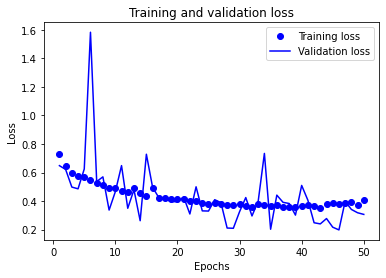

In [ ]:
plot_loss(history_1)

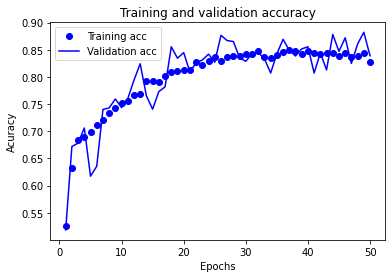

In [ ]:
plot_acc(history_1)

In the loss plot, the training loss decreased stably, and though the validation loss was not as stable, it still followed the trend to decrease.

In the accuracy plot, both training and validation accuracy increase stably. And it also shows that after around 30 epochs, the accuracy seems to stop improving.

In [ ]:
del model_1
gc.collect()

Remider: Since I stored every model, you supposed to delete the models stored in the disk if you use Colab to avoid reaching the limitation of disk.

##### Predict if the test images are having defects
I have run the first model twice and the above results was the second time. However, I found that the validation accuracy was higher in the first time so I used that version to predict. And I also put the hdf5 file in the cloud folder for your use.
(But actually, the public leaderboard score has only small difference(around 0.002)between using the best model trained in the first and second time.)

In [ ]:
model_1 = load_model(base_dir + '/model_1_weights-47-0.92.hdf5')

In [ ]:
output_1 = model_1.predict_generator(test_gen)
output_1.shape

(3770, 1)

The shape of output_1 is (3770,1). The length is the same as the testing images count, and the one dimensional output is a probability of having no defects.

In [ ]:
# Add the predicted value into test_df and convert the probabilities into 0 or 1 for indication of defects
# I simply use 0.5 as the threshold for 0 and 1
test_df['No defect prob'] = output_1
test_df['No defect'] = (test_df['No defect prob'] > 0.5).astype('int')
test_df.head()

,File name,ImageId,No defect prob,No defect
0,4.JPG,4,0.999969,1
1,10.JPG,10,0.999998,1
2,11.JPG,11,0.999841,1
3,15.JPG,15,0.375066,0
4,17.JPG,17,0.106881,0


In [ ]:
print("The total test images:", len(test_df))
print("The number of images  without defects: ", test_df['No defect'].sum())

The total test images: 3770
The number of images  without defects:  1641


There are 1676 images with no defect, so we need to predict on the left 2094 for pixelwise defect prediction.

In [ ]:
# Create defect_test_df which only contains images predicted to have defects
defect_test_df = test_df[ test_df['No defect'] == 0].copy().reset_index(drop = True)
defect_test_df.head()

,File name,ImageId,No defect prob,No defect
0,15.JPG,15,3.750660e-01,0
1,17.JPG,17,1.068813e-01,0
2,23.JPG,23,1.453403e-02,0
3,31.JPG,31,7.283529e-29,0
4,34.JPG,34,6.180525e-03,0


#### Second model - detect the pixelwise defect location

##### Build data generator

In [ ]:
class DataGenerator(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, df, target_df=None, mode='fit',
                base_path = train_dir +'/', batch_size=20, dim=(256, 1600), n_channels=1,
                n_classes=4, random_state=10, shuffle=True):
    self.dim = dim
    self.batch_size = batch_size
    self.df = df
    self.mode = mode
    self.base_path = base_path
    self.target_df = target_df
    self.defect_IDs = df['ImageId'].tolist()
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.random_state = random_state
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.defect_IDs) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Find list of IDs
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    defect_IDs_batch = [self.defect_IDs[k] for k in indexes]
    X = self.__generate_X(defect_IDs_batch)

    if self.mode == 'fit':
      y = self.__generate_y(defect_IDs_batch)
      return X, y
    elif self.mode == 'predict':
      return X
    else:
      raise AttributeError('The mode parameter should be set to "fit" or "predict".')

  def on_epoch_end(self):
    'Updates indexes after each epoch to have different orders after shuffled'
    self.indexes = np.arange(len(self.defect_IDs))
    if self.shuffle == True:
        np.random.seed(self.random_state)
        np.random.shuffle(self.indexes)

  def __generate_X(self, defect_IDs_batch):
    'generate data with batch_size samples'
    X = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))
    for i, ID in enumerate(defect_IDs_batch):
      img_path = (self.base_path + str(ID) + '.JPG')
      img = self.__load_grayscale(img_path)
      X[i,] = img
    return X

  def __generate_y(self, defect_IDs_batch):
    'generate y_labels with batch_size samples'
    y = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_classes), dtype=int)

    for i, ID in enumerate(defect_IDs_batch):
      image_df = self.target_df[self.target_df['ImageId'] == ID]
      image_category = image_df['ClassId'].tolist()
      rles = image_df['EncodedPixels'].values
      matrix = build_matrices(image_category= image_category, rles= rles, input_shape=self.dim)

      y[i, ] = matrix
    return y

  def __load_grayscale(self, img_path):
    'load images in grayscale and do preprocessing'
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = image.astype(np.float32) / 255.
    image = np.expand_dims(image, axis=-1)
    return image

In [ ]:
from keras import backend as K

Build dice_coef function by the defenition

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))

In [ ]:
BATCH_SIZE = 30

# Split the training data into sub_training(85%) and validation(15%) data
train_set, val_set = train_test_split(
    defect_train_df,
    random_state=10,
    test_size=0.15
)

# Create training data generator
train_generator = DataGenerator(
    df = train_set,
    target_df=train_csv,
    batch_size=BATCH_SIZE,
    n_classes=4
)

# Create validation data generator
val_generator = DataGenerator(
    df = val_set,
    target_df=train_csv,
    batch_size=BATCH_SIZE,
    n_classes=4
)

In [ ]:
def build_second_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

    return model

In [ ]:
model_2 = build_second_model((256,1600,1))
model_2.summary()

In [ ]:
checkpoint = ModelCheckpoint(
    'weights-{epoch:02d}-{val_dice_coef:.2f}.hdf5',
    verbose=2,
    save_best_only=False,
    save_weights_only=False,
    mode='auto'
)


history_2 = model_2.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    epochs=40
)

Epoch 1/40
132/132 [==============================] - 1314s 10s/step - loss: 0.5386 - dice_coef: 0.0163 - val_loss: 0.3990 - val_dice_coef: 0.0255

Epoch 00001: saving model to weights-01-0.03.hdf5
Epoch 2/40
132/132 [==============================] - 99s 749ms/step - loss: 0.2602 - dice_coef: 0.0297 - val_loss: 0.0701 - val_dice_coef: 0.0927

Epoch 00002: saving model to weights-02-0.09.hdf5
Epoch 3/40
132/132 [==============================] - 97s 736ms/step - loss: 0.0513 - dice_coef: 0.1987 - val_loss: 0.0300 - val_dice_coef: 0.2470

Epoch 00003: saving model to weights-03-0.25.hdf5
Epoch 4/40
132/132 [==============================] - 99s 747ms/step - loss: 0.0409 - dice_coef: 0.2803 - val_loss: 0.0278 - val_dice_coef: 0.3294

Epoch 00004: saving model to weights-04-0.33.hdf5
Epoch 5/40
132/132 [==============================] - 98s 743ms/step - loss: 0.0378 - dice_coef: 0.3342 - val_loss: 0.0291 - val_dice_coef: 0.4006

Epoch 00005: saving model to weights-05-0.40.hdf5
Epoch 6/40

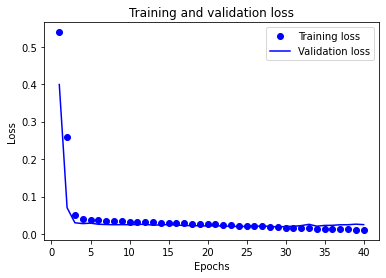

In [ ]:
plot_loss(history_2)

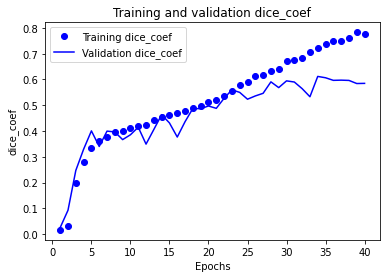

In [ ]:
plot_dice_coef(history_2)

In [ ]:
del model_2
gc.collect()

##### Make predictions
I chose the best version(with lowest val_loss and high val_dice_coef) as the model for prediction. And I also provided that in the cloud for your reference.

In [ ]:
model_2 = load_model(base_dir + '/model_2_weights-34-0.61.hdf5', custom_objects={'dice_coef':dice_coef})

In [ ]:
# Create the dataframe for final submission, named sub_df
sub_df = pd.DataFrame(columns = ['ImageId', 'ClassId', 'EncodedPixels'])

# Make predictions
for i in range(0, defect_test_df.shape[0], 300):
    """
    Since it would run out of RAM if we want to store all predicted pixels at once,
    I only made predictions on 300 images and transformed them to ideal format, and then shifted to the next round.
    """
    batch_idx = list( range(i, min(defect_test_df.shape[0], i + 300)))

    # Generatir test image data in batch
    test_generator = DataGenerator(
        df=defect_test_df.iloc[batch_idx],
        shuffle=False,
        mode='predict',
        base_path=test_dir+'/',
        target_df=None,
        batch_size=1,
        n_classes=4
    )

    # Make prediction
    batch_pred_matrices = model_2.predict_generator(test_generator, verbose=1)

    # Add the predicted information to the dataframe after each round of prediction
    for j, b in enumerate(batch_idx):
        ImageId = defect_test_df.iloc[b,1]
        # Here use round to transform all entries into 0 and 1, which means that the threshold is 0.5
        pred_matrices = batch_pred_matrices[j, ].round().astype(int)
        pred_rles = build_rles(pred_matrices)
        image_df = pd.DataFrame(columns = ['ImageId', 'ClassId', 'EncodedPixels'])
        image_df['ImageId'] = [ImageId,ImageId,ImageId,ImageId ]
        image_df['EncodedPixels'] = pred_rles
        image_df['ClassId'] = [1,2,3,4]
        sub_df = sub_df.append(image_df, ignore_index=True)

29/29 [==============================] - 7s 241ms/step


In [ ]:
sub_df.head(20)

,ImageId,ClassId,EncodedPixels
0,15,1,147434 1
1,15,2,
2,15,3,
3,15,4,
4,17,1,
5,17,2,
6,17,3,191315 4 191570 5 191814 3 191824 8 192069 1 1...
7,17,4,8795 3 8799 3 8803 2 9051 7 9059 3 9301 22 955...
8,23,1,
9,23,2,


In [ ]:
# Extract only the rows with defect predicted
final_sub_df = sub_df[ sub_df['EncodedPixels'] != ""]
final_sub_df.head(10)

,ImageId,ClassId,EncodedPixels
0,15,1,147434 1
6,17,3,191315 4 191570 5 191814 3 191824 8 192069 1 1...
7,17,4,8795 3 8799 3 8803 2 9051 7 9059 3 9301 22 955...
10,23,3,319369 13 319623 18 319875 22 320130 24 320385...
14,31,3,25482 4 25736 9 25991 11 26244 17 26282 6 2649...
18,34,3,72507 7 72758 23 72782 5 72788 1 72792 1 72804...
22,52,3,280744 5 280998 13 281252 17 281497 1 281504 2...
26,55,3,290537 11 290787 19 291040 23 291291 28 291516...
30,61,3,309316 1 309570 11 309820 1 309822 1 309824 16...
32,66,1,77076 22 77327 1 77329 27 77578 1 77580 1 7758...


In [ ]:
final_sub_df['ClassId'].value_counts()

3    1860
4     470
1     302
2      49
Name: ClassId, dtype: int64

In [ ]:
final_sub_df.shape

(2681, 3)

In [ ]:
final_sub_df.to_csv("Submission.csv", index = False)
files.download("Submission.csv")

**References**

In this practice, except for the lectures and tutorials in the course of Quantative Business Science, I also took the following notebooks on Kaggle as refereneces and discussed with my classmate.
1. https://www.kaggle.com/xhlulu/severstal-simple-2-step-pipeline (https://www.kaggle.com/xhlulu/severstal-simple-2-step-pipeline)
2. https://www.kaggle.com/cdeotte/keras-unet-with-eda (https://www.kaggle.com/cdeotte/keras-unet-with-eda)